Thanks to [Iafoss](https://www.kaggle.com/iafoss) for the great code for the start!

Below is a notebook I changed a little.

---

# Description
Greetings, this kernel provides fast.ai starter code for Bengali.AI Handwritten Grapheme Classification competition.

The task proposed in this competition is recognition of handwritten Bengali letters. In contrast to similar competitions such as [mnist digit recognition](https://www.kaggle.com/c/digit-recognizer) or the recent [Kannada MNIST](https://www.kaggle.com/c/Kannada-MNIST), Bengali alphabet is quite complex and may include ~13,000 different grapheme variations. Fortunately, each grapheme can be decomposed into 3 parts: grapheme_root, vowel_diacritic, and consonant_diacritic (168, 11, and 7 independent classes, respectively). Therefore, the task of grapheme recognition is significantly simplified in comparison with 13k-way classification. Though, additional consideration may be required for this multitask classification, like checking if 3 independent models, or a single model one head, or a single model with 3 heads (this kernel) works the best. This kernel is mostly based on [Iafoss findings](https://www.kaggle.com/c/Kannada-MNIST/discussion/122430) in a recent Kannada MNIST toy competition.

Because the data has much higher resolution than MNIST or CIFAR, the things that work there may be less applicable to this data, while ImageNet based solutions should be more suitable. So, I've choosen DenseNet121 as a starter network.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import os
from sklearn.model_selection import KFold
from radam import *
from csvlogger import *
from mish_activation import *
import warnings
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.59'

In [2]:
sz = 128
bs = 128
nfolds = 4 #keep the same split as the initial dataset
fold = 0
SEED = 2019
TRAIN = '../input/grapheme-imgs-128x128/'
LABELS = '../input/bengaliai-cv19/train.csv'
arch = models.densenet121

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data

In [3]:
df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.head()

[168, 11, 7]


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


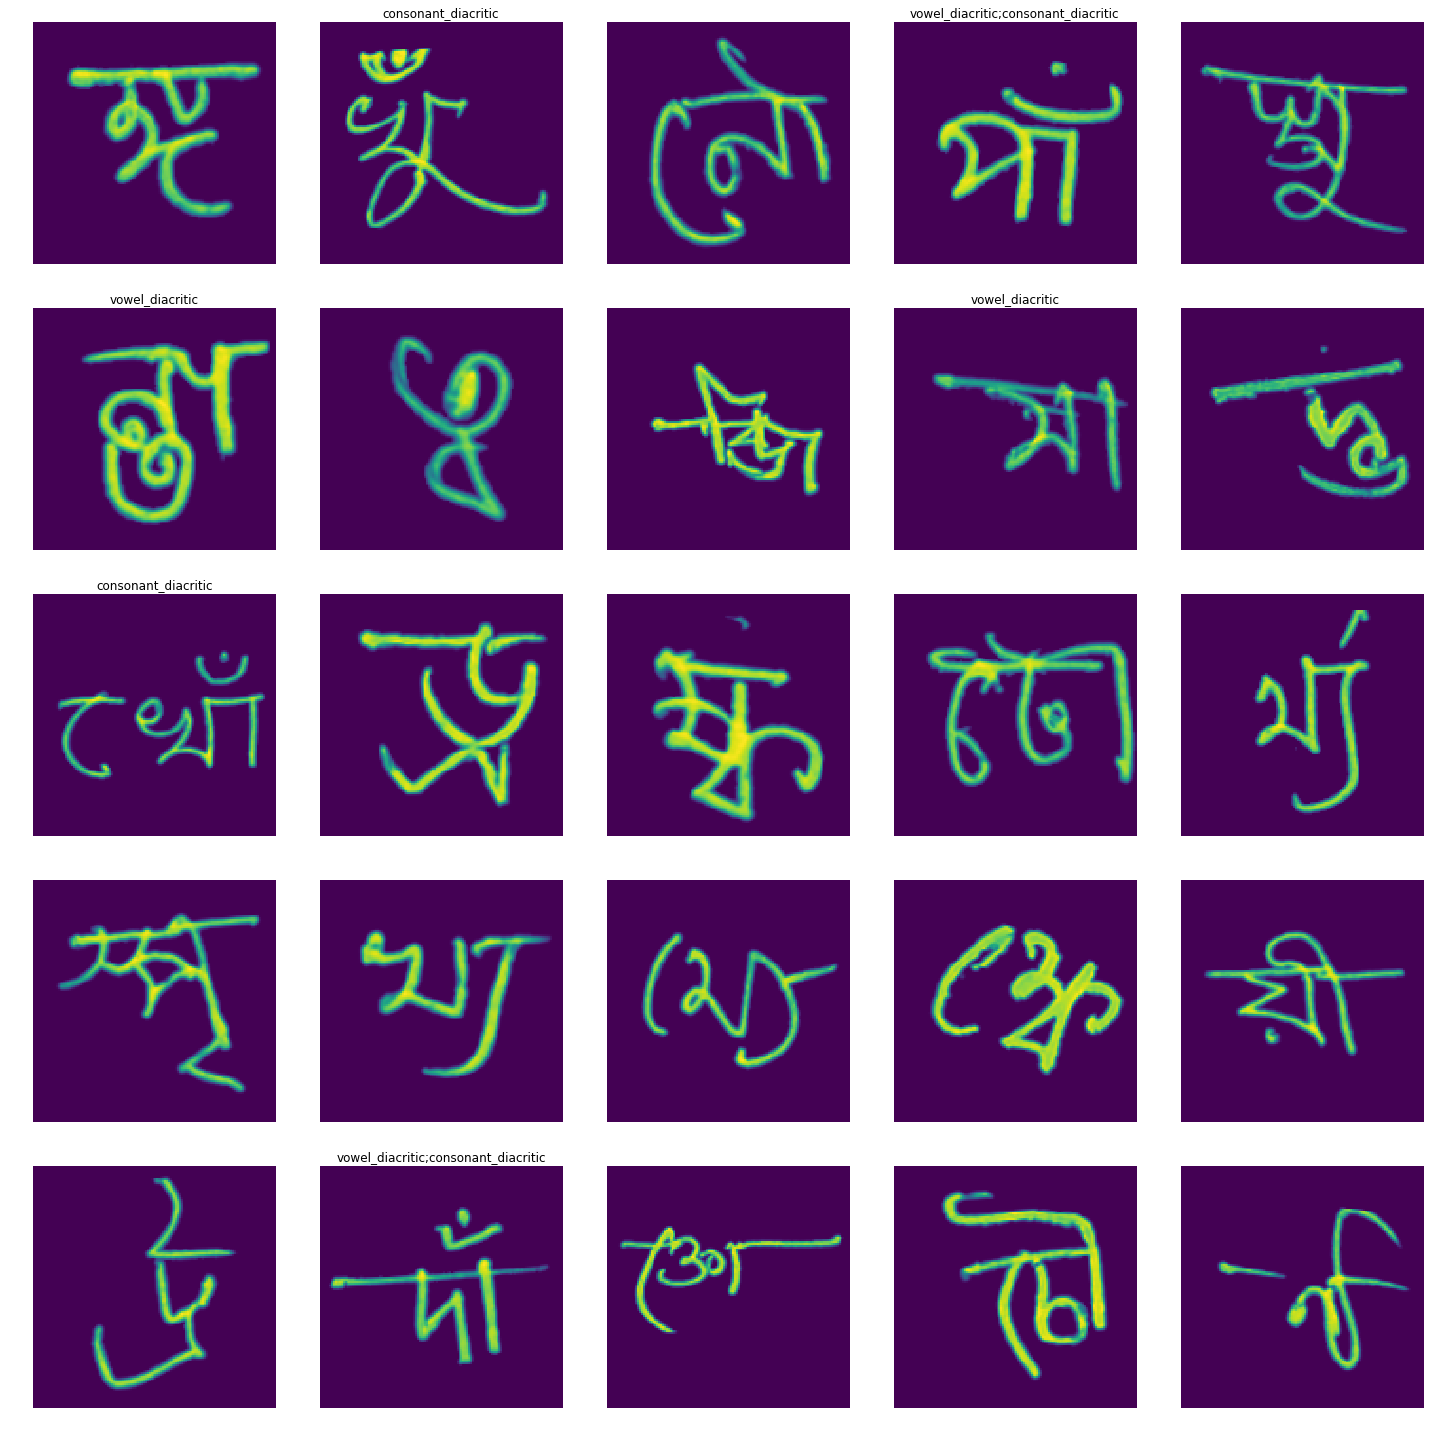

In [4]:
stats = ([0.0692], [0.2051])
data = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

data.show_batch()

# Model

The starter model is based on DenseNet121, which [Iafoss](https://www.kaggle.com/iafoss) found to work quite well for such kind of problems. The first conv is replaced to accommodate for 1 channel input, and the corresponding pretrained weights are summed. ReLU activation in the head is replaced by Mish, which works noticeably better for all tasks Iafoss checked it so far. Since each portion of the prediction (grapheme_root, vowel_diacritic, and consonant_diacritic) is quite independent concept, I create a separate head for each of them.

In [5]:
class Head(nn.Module):
    def __init__(self, nc, n, ps=0.5):
        super().__init__()
        layers = [AdaptiveConcatPool2d(), Mish(), Flatten()] + \
            bn_drop_lin(nc*2, 512, True, ps, Mish()) + \
            bn_drop_lin(512, n, True, ps)
        self.fc = nn.Sequential(*layers)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)

#change the first conv to accept 1 chanel input
class Dnet_1ch(nn.Module):
    def __init__(self, arch=arch, n=nunique, pre=True, ps=0.5):
        super().__init__()
        m = arch(True) if pre else arch()
        
        conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        w = (m.features.conv0.weight.sum(1)).unsqueeze(1)
        conv.weight = nn.Parameter(w)
        
        self.layer0 = nn.Sequential(conv, m.features.norm0, nn.ReLU(inplace=True))
        self.layer1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
            m.features.denseblock1)
        self.layer2 = nn.Sequential(m.features.transition1,m.features.denseblock2)
        self.layer3 = nn.Sequential(m.features.transition2,m.features.denseblock3)
        self.layer4 = nn.Sequential(m.features.transition3,m.features.denseblock4,
                                    m.features.norm5)
        
        nc = self.layer4[-1].weight.shape[0]
        self.head1 = Head(nc,n[0])
        self.head2 = Head(nc,n[1])
        self.head3 = Head(nc,n[2])
        #to_Mish(self.layer0), to_Mish(self.layer1), to_Mish(self.layer2)
        #to_Mish(self.layer3), to_Mish(self.layer4)
        
    def forward(self, x):    
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        
        return x1,x2,x3

# Loss

Cross entropy loss is applied independently to each part of the prediction and the result is summed with the corresponding weight.

In [6]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 0.5*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.25*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          0.25*F.cross_entropy(x3,y[:,2],reduction=reduction)

The code below computes the competition metric and recall macro metrics for individual components of the prediction. The code is partially borrowed from fast.ai.

In [7]:
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [8]:
#fix the issue in fast.ai of saving gradients along with weights
#so only weights are written, and files are ~4 times smaller

class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto',
                 every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": 
            #self.learn.save(f'{self.name}_{epoch}')
            torch.save(learn.model.state_dict(),f'{self.name}_{epoch}.pth')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                #print(f'Better model found at epoch {epoch} \
                #  with {self.monitor} value: {current}.')
                self.best = current
                #self.learn.save(f'{self.name}')
                torch.save(learn.model.state_dict(),f'{self.name}.pth')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and os.path.isfile(f'{self.name}.pth'):
            #self.learn.load(f'{self.name}', purge=False)
            self.model.load_state_dict(torch.load(f'{self.name}.pth'))

# MixUp

The code below modifies fast.ai MixUp calback to make it compatible with the current data.

In [9]:
class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3].long()), self.crit(output,target[:,3:6].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

# Training

[Iafoss](https://www.kaggle.com/iafoss) have performed a check of different optimizers and schedules on a [similar task](https://www.kaggle.com/c/Kannada-MNIST/discussion/122430), and [Over9000 optimizer](https://github.com/mgrankin/over9000) cosine annealing **without warm-up** worked the best. Freezing the backbone at the initial stage of training didn't give me any advantage in that test, so here I perform the training straight a way with discriminative learning rate (smaller lr for backbone).

In [12]:
model = Dnet_1ch()
learn = Learner(data, model, loss_func=Loss_combine(), opt_func=Over9000,
        metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()])
logger = CSVLogger(learn,f'log{fold}')
learn.clip_grad = 1.0
learn.split([model.head1])
learn.unfreeze()

In [15]:
learn.fit_one_cycle(32, max_lr=slice(0.2e-2,1e-2), wd=[1e-3,0.1e-1], pct_start=0.0, 
    div_factor=100, callbacks = [logger, SaveModelCallback(learn,monitor='metric_tot',
    mode='max',name=f'model_{fold}'),MixUpCallback(learn)])
#metrics: Metric_grapheme, Metric_vowel, Metric_consonant, Metric_tot (competition metric)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.125750,0.255639,0.858340,0.950945,0.898026,0.891413,15:16
1,0.998632,0.187273,0.907721,0.963396,0.941169,0.930001,13:26
2,0.953570,0.159625,0.918451,0.972815,0.966408,0.944031,13:25
3,0.889834,0.149943,0.919746,0.978245,0.975026,0.948191,15:54
4,0.860344,0.134184,0.930021,0.976702,0.972582,0.952332,13:19
5,0.808975,0.127720,0.936182,0.978096,0.970619,0.955270,13:35
6,0.778455,0.129206,0.939219,0.978478,0.965266,0.955545,13:28
7,0.737100,0.118606,0.942327,0.980720,0.976303,0.960419,13:18
8,0.718830,0.115389,0.941996,0.981659,0.977169,0.960705,13:25
9,0.693336,0.109947,0.947478,0.980332,0.979586,0.963719,13:34
